In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import dftqml.utils
import dftqml.tfmodel
import dftqml.xgb
from os import path

CNN_DIR = "../main/models/base/"
XGB_DIR = "../main/models/xgb/"
DATA_DIR = "../main/data-h5"
N_SPLITS = 5
EXACT = "exact"
HARMONIC_EXACT = "harmonic_exact"
HARMONIC_POTENTIALS = "harmonic_potentials"

def sampling_source(nshots):
    return path.join("sampling", f"nshots{nshots}")


def vha_source(depth):
    return path.join("vha-vqe", f"depth{depth}")

def npf_source(depth):
    return path.join("npfabric-slsqp-init", f"depth{depth}")


def cnn_path(L, N, U, source, ndata, split):
    return path.join(CNN_DIR, f"L{L}-N{N}-U{U}", source, f"ndata{ndata}", f"split{split}")


def xgb_path(L, N, U, source, ndata, split):
    return path.join(XGB_DIR, f"L{L}-N{N}-U{U}", source, f"ndata{ndata}", f"split{split}")


def data_path(L, N, U, source):
    return path.join(DATA_DIR, f"L{L}-N{N}-U{U}", source)


def history_plot(history_dict):
    plt.plot(history_dict["mse"], label="mse")
    plt.plot(history_dict["val_mse"], label="val_mse")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (mse)")
    plt.grid()
    plt.yscale("log")
    plt.legend()


def mse(prediction, exact):
    return np.mean((np.ravel(prediction) - np.ravel(exact)) ** 2)

2025-03-05 13:02:40.567652: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 13:02:40.770886: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-05 13:02:40.771011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-05 13:02:40.810957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 13:02:40.893590: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 13:02:40.895457: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
L = 8
N = 4
U = 4.0

exact_densities, exact_energies = dftqml.utils.load_dft_data(data_path(L, N, U, EXACT), 2000)
train_x = exact_densities[:1000]
train_y = exact_energies[:1000]
test_x = exact_densities[1000:]
test_y = exact_energies[1000:]

# visualize a single model 

## CNN and XGB trained on Exact data

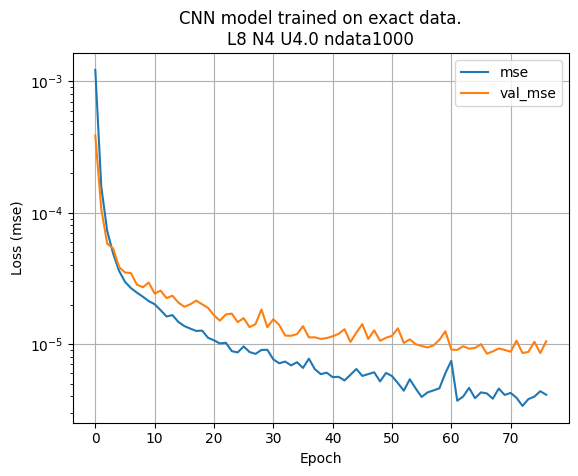

MSE on test set: 8.816472123786279e-06


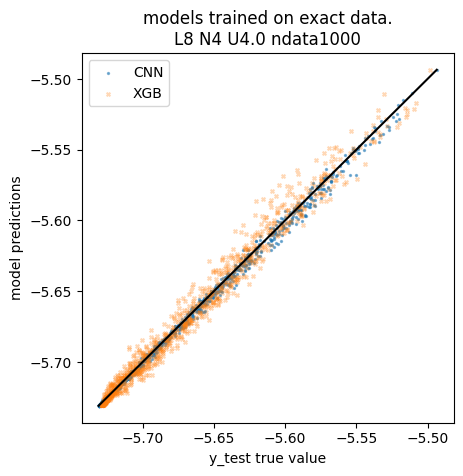

In [3]:
ndata = 1000
plt.title("CNN model trained on exact data.\n" f"L{L} N{N} U{U} ndata{ndata}")
model, history_dict = dftqml.tfmodel.load_model(
    cnn_path(L, N, U, EXACT, ndata, 0), get_history_dict=True
)

history_plot(history_dict)
plt.show()

xgb_model = dftqml.xgb.load_xgb(xgb_path(L, N, U, EXACT, ndata, 0))

plt.figure(figsize=plt.figaspect(1))

plt.title("models trained on exact data.\n" f"L{L} N{N} U{U} ndata{ndata}")
dftqml.utils.performance_plot(model, test_x, test_y, label="CNN", s=2, alpha=0.5)
plt.scatter(np.ravel(xgb_model.predict(test_x)), test_y, label="XGB", marker='x', s=7, alpha=0.3)
plt.legend()
print("MSE on test set:", mse(model(test_x), test_y))

## CNN trained on EVE (sampling) data

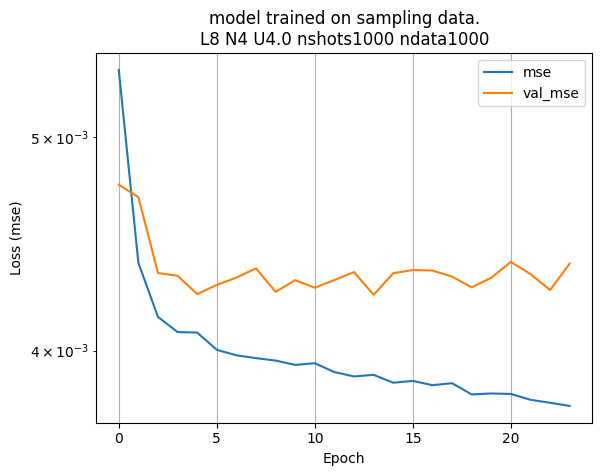

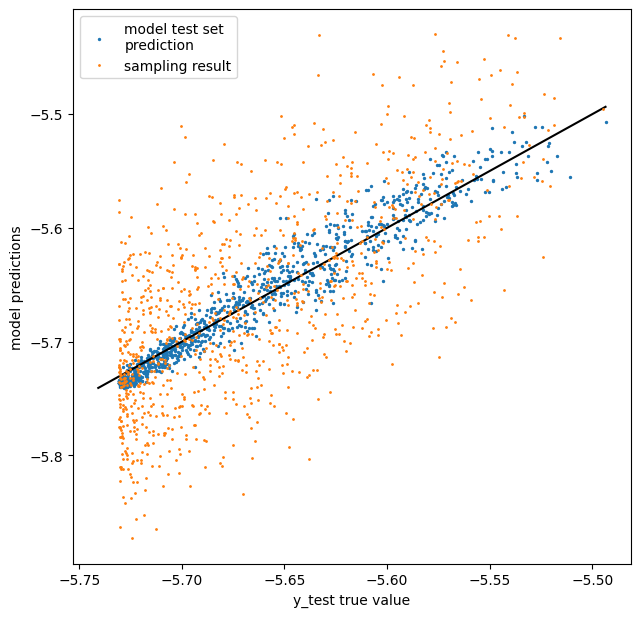

In [4]:
ndata = 1000
nshots = 1000

plt.title("model trained on sampling data.\n" f"L{L} N{N} U{U} nshots{nshots} ndata{ndata}")
model, history_dict = dftqml.tfmodel.load_model(
    cnn_path(L, N, U, sampling_source(nshots), ndata, 0), get_history_dict=True
)

history_plot(history_dict)
plt.show()

plt.figure(figsize=1.5 * plt.figaspect(1))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
dftqml.utils.performance_plot(
    model, test_x, test_y, s=2, c=colors[0], label="model test set\nprediction"
)

sampling_densities, sampling_energies = dftqml.utils.load_dft_data(
    data_path(L, N, U, sampling_source(nshots)), 1000
)
plt.plot(exact_energies[:1000], sampling_energies, ".", c=colors[1], ms=2, label="sampling result")
plt.legend()

## CNN trained on VQE (NPF)

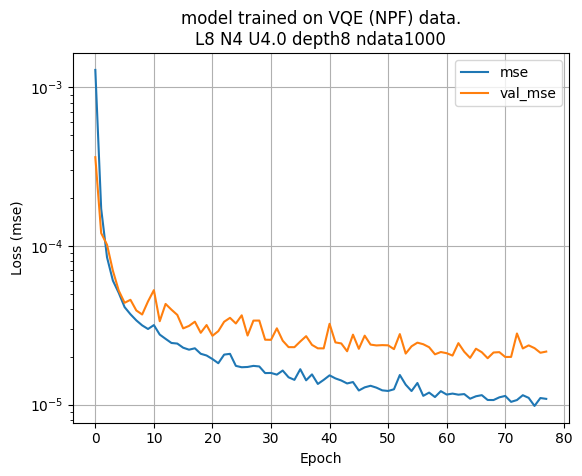

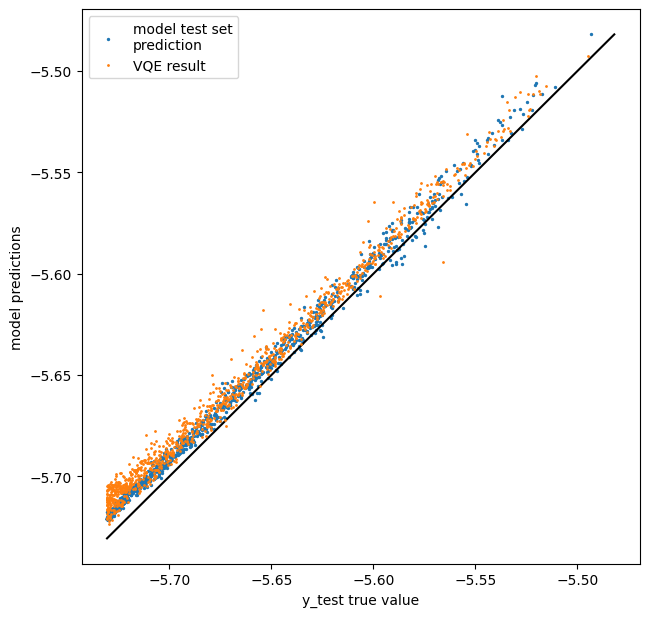

In [5]:
ndata = 1000
depth = 8
plt.title("model trained on VQE (NPF) data.\n" f"L{L} N{N} U{U} depth{depth} ndata{ndata}")
model, history_dict = dftqml.tfmodel.load_model(
    cnn_path(L, N, U, npf_source(depth), ndata, 0), get_history_dict=True
)

history_plot(history_dict)
plt.show()

plt.figure(figsize=1.5 * plt.figaspect(1))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
dftqml.utils.performance_plot(
    model, test_x, test_y, s=2, c=colors[0], label="model test set\nprediction"
)

vqe_densities, vqe_energies = dftqml.utils.load_dft_data(
    data_path(L, N, U, npf_source(depth)), 1000
)
plt.plot(exact_energies[:1000], vqe_energies, ".", ms=2, c=colors[1], label="VQE result")
plt.legend()

# performance plot for all datasets

## EVE (Sampling)

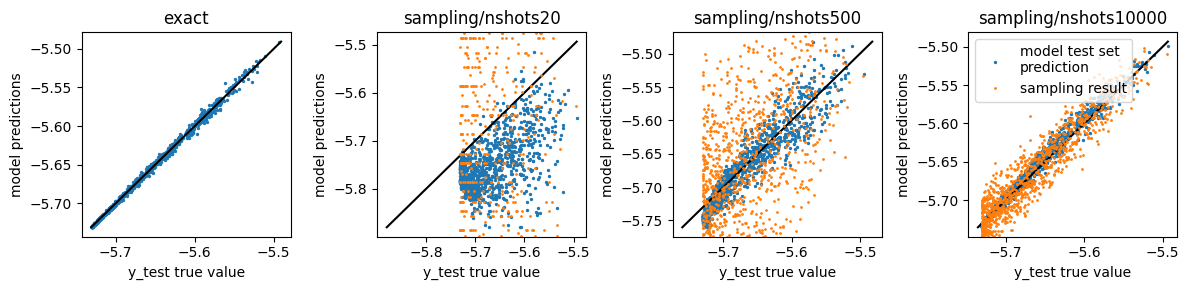

In [6]:
ndata = 1000
source_list = [EXACT, sampling_source(20), sampling_source(500), sampling_source(10000)]

fig, axlist = plt.subplots(1, len(source_list), figsize=(3 * len(source_list), 3))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, source in enumerate(source_list):
    plt.sca(axlist[i])
    # plt.subplot(1, len(source_list), i + 1)
    plt.title(source)

    model, history_dict = dftqml.tfmodel.load_model(
        cnn_path(L, N, U, source, ndata, 1), get_history_dict=True
    )
    dftqml.utils.performance_plot(
        model, test_x, test_y, s=2, c=colors[0], label="model test set\nprediction"
    )
    plt.ylim(*plt.gca().get_xlim())

    if source != EXACT:
        sampling_densities, sampling_energies = dftqml.utils.load_dft_data(
            data_path(L, N, U, source), 1000
        )
        plt.plot(
            exact_energies[:1000],
            sampling_energies,
            ".",
            c=colors[1],
            ms=2,
            label="sampling result",
        )

plt.legend()
plt.tight_layout()

## VQE (VHA)

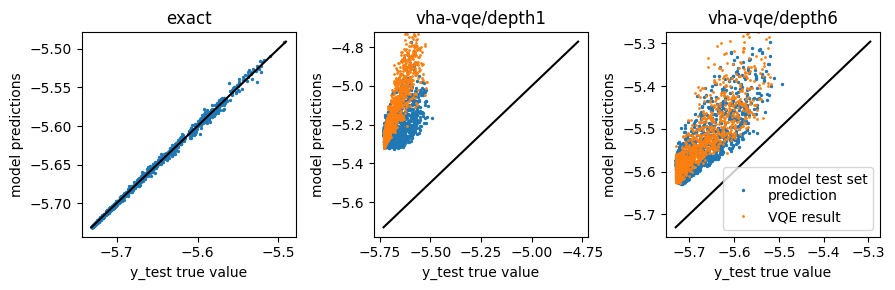

In [7]:
ndata = 1000
source_list = [EXACT, vha_source(1), vha_source(6)]

fig, axlist = plt.subplots(1, len(source_list), figsize=(3 * len(source_list), 3))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, source in enumerate(source_list):
    plt.sca(axlist[i])
    #plt.subplot(1, len(source_list), i + 1)
    plt.title(source)

    model, history_dict = dftqml.tfmodel.load_model(
        cnn_path(L, N, U, source, ndata, 1), get_history_dict=True
    )
    dftqml.utils.performance_plot(
        model, test_x, test_y, s=2, c=colors[0], label="model test set\nprediction"
    )
    plt.ylim(*plt.gca().get_xlim())

    if source != EXACT:
        vqe_densities, vqe_energies = dftqml.utils.load_dft_data(
            data_path(L, N, U, source), 1000
        )
        plt.plot(exact_energies[:1000], vqe_energies, ".", c=colors[1], ms=2, label="VQE result")

plt.legend()
plt.tight_layout()

## Combined

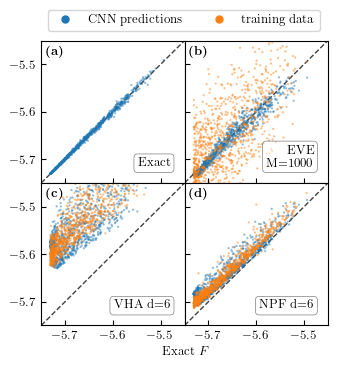

In [8]:
from matplotlib.lines import Line2D

ms = 2.5
alpha = 0.5

ndata = 1000
source_list = [EXACT, sampling_source(1000), vha_source(6), npf_source(6)]

with plt.style.context("figstyle.mplstyle"):
    fig, axlist = plt.subplots(2, 2, figsize=(3.7, 3.7), sharex=True, sharey=True)
    axlist = axlist.ravel()
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    lims = [-5.75, -5.45]

    titles = ["Exact", "EVE\nM=1000",
            #"Sampling\nnshots=2000",
            "VHA d=6",
            "NPF d=6"]
            #"VQE NPF\ndepth=11"]#,"VQE ]

    for i, source in enumerate(source_list):
        axlist[i].text(
            -5.48,
            -5.72,
            titles[i],
            ha="right",
            va="bottom",
            bbox=dict(facecolor="white", edgecolor="black", lw=0.5, boxstyle="round", alpha=0.5),
        )

        model, history_dict = dftqml.tfmodel.load_model(
            cnn_path(L, N, U, source, ndata, 1), get_history_dict=True
        )
        prediction = np.ravel(model(test_x).numpy())

        axlist[i].scatter(test_y, prediction, s=ms, alpha=alpha, zorder=0, edgecolors='none')
        #lims = [np.min([test_y, prediction]), np.max([test_y, prediction])]
        axlist[i].plot(lims, lims, "k--", alpha=0.75, lw=1, zorder=-1)

        # axlist[i].set_ylim(*axlist[i].get_xlim())

        if source != EXACT:
            _, train_energies = dftqml.utils.load_dft_data(data_path(L, N, U, source), 1000)
            axlist[i].scatter(
                exact_energies[:1000],
                train_energies,
                s=ms,
                alpha=alpha,
                zorder=1,
                edgecolors='none'
            )

    axlist[0].set_xlim(*lims)
    axlist[0].set_ylim(*lims)


    blue_dot = Line2D([], [], color=colors[0], marker="o", linestyle="None", markersize=5)
    orange_dot = Line2D([], [], color=colors[1], marker="o", linestyle="None", markersize=5)

    handles = [blue_dot, orange_dot]
    labels = ["CNN predictions", "training data"]
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor= (0.51, 0.98), ncol=2)

    #axlist[0].set_ylabel("Prediction or data", y=0)
    axlist[2].set_xlabel(r"Exact $F$", x=1)

    plt.subplots_adjust(hspace=0, wspace=0)
    lim = (plt.gca().get_xlim()[0] + 0.01, plt.gca().get_ylim()[1]-0.01) 
    for i, ax in enumerate(axlist):
        ax.text(*lim, r'\textbf{('f'{chr(97+i)}'r')}', ha="left", va="top")

    plt.show()

## Performance plot on harmonic potentials

In [9]:
N_MAX_HARMONIC = 280
harmonic_potentials, strengths = dftqml.utils.load_harmonic_potentials(data_path(L, N, U, HARMONIC_POTENTIALS) + '.h5', N_MAX_HARMONIC, 0)
harmonic_densities, harmonic_energies = dftqml.utils.load_dft_data(data_path(L, N, U, HARMONIC_EXACT) + '.h5', N_MAX_HARMONIC)


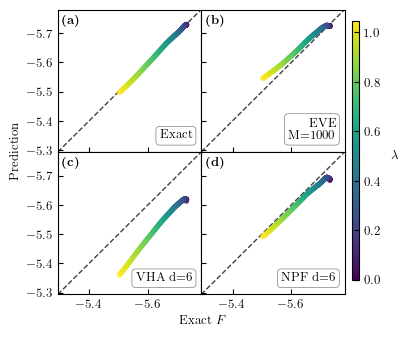

In [ ]:

from matplotlib.lines import Line2D

ms = 15
alpha = 0.5

ndata = 1000
source_list = [EXACT, sampling_source(1000), vha_source(6), npf_source(6)]

with plt.style.context("figstyle.mplstyle"):
    fig, axlist = plt.subplots(2, 2, figsize=(3.7, 3.7), sharex=True, sharey=True)
    axlist = axlist.ravel()
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # lims = [-5.75, -5.45]
    # lims = [np.max(exact_energies)+0.4, np.min(exact_energies)-0.05]

    lims = [np.max(exact_energies)+0.2, np.min(exact_energies)-0.05]

    titles = ["Exact", "EVE\nM=1000",
            #"Sampling\nnshots=2000",
            "VHA d=6",
            "NPF d=6"]
            #"VQE NPF\ndepth=11"]#,"VQE ]

    # Define the colormap and normalization for all subplots
    vmin, vmax = np.min(strengths), np.max(strengths)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.viridis

    for i, source in enumerate(source_list):
        axlist[i].text(
            -5.75,
            -5.33,
            titles[i],
            ha="right",
            va="bottom",
            bbox=dict(facecolor="white", edgecolor="black", lw=0.5, boxstyle="round", alpha=0.5),
        )

        model, history_dict = dftqml.tfmodel.load_model(
            cnn_path(L, N, U, source, ndata, 1), get_history_dict=True
        )
        prediction = np.ravel(model(harmonic_densities).numpy())

        axlist[i].scatter(harmonic_energies, prediction, s=ms, alpha=alpha, zorder=0, edgecolors='none',c=strengths, cmap=cmap, norm=norm)
        axlist[i].plot(lims, lims, "k--", alpha=0.75, lw=1, zorder=-1)


    axlist[0].set_xlim(*lims)
    axlist[0].set_ylim(*lims)


    blue_dot = Line2D([], [], color=colors[0], marker="o", linestyle="None", markersize=5)
    orange_dot = Line2D([], [], color=colors[1], marker="o", linestyle="None", markersize=5)

    axlist[0].set_ylabel("Prediction", y=0)
    axlist[2].set_xlabel(r"Exact $F$", x=1)

    plt.subplots_adjust(hspace=0, wspace=0)
    lim = (plt.gca().get_xlim()[0] - 0.015, plt.gca().get_ylim()[1]+0.015) 
    for i, ax in enumerate(axlist):
        ax.text(*lim, r'\textbf{('f'{chr(97+i)}'r')}', ha="left", va="top")
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position the colorbar
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)  # Create a ScalarMappable
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label(r"$\lambda$", rotation=0, labelpad=10)

    plt.show()

# Systematic MSE comparison (and xval plots)

## Sampling

In [ ]:
nshots_list = np.array(
    [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]
)
source_list = [sampling_source(ns) for ns in nshots_list] + [EXACT]

kfold_xval_mse = np.zeros((len(source_list), N_SPLITS))
kfold_test_mse = np.zeros((len(source_list), N_SPLITS))
ndata = 1000

for srcidx, source in enumerate(source_list):
    for split in range(N_SPLITS):
        model, history = dftqml.tfmodel.load_model(
            cnn_path(L, N, U, source, ndata, split), get_history_dict=True
        )
        kfold_xval_mse[srcidx, split] = history["val_mse"][-1]
        kfold_test_mse[srcidx, split] = mse(model(test_x), test_y)

### xval plot

In [ ]:
plt.title("5-fold cross-validation\n" f"L{L} N{N} U{U} ndata{ndata}")
plt.plot(nshots_list, kfold_xval_mse[:-1], "_k")
plt.errorbar(
    nshots_list,
    np.mean(kfold_xval_mse[:-1], axis=1),
    yerr=np.std(kfold_xval_mse[:-1], axis=1),
    fmt="x",
    color="r",
)
plt.plot(nshots_list, 4/nshots_list, ':k', label="4/nshots")
plt.ylabel("cross-validation loss (MSE)")
plt.xlabel("number of samples")
plt.yscale("log")
plt.xscale('log')
plt.legend()
plt.show()

### test set run

In [ ]:
sampling_mse = np.zeros((len(source_list)))
sampling_errors = np.zeros((len(source_list), 1000))

for srcidx, source in enumerate(source_list):
    if source == EXACT:
        continue  # no need to compute exact vs exact mse
    sampling_densities, sampling_energies = dftqml.utils.load_dft_data(
        data_path(L, N, U, source), 1000
    )
    sampling_errors[srcidx] = sampling_energies - exact_energies[:1000]
    sampling_mse[srcidx] = mse(sampling_energies, exact_energies[:1000])

In [ ]:
with plt.style.context("figstyle.mplstyle"):
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    fig, ax = plt.subplots(figsize=(3.5,2.4))

    ax.errorbar(
        nshots_list,
        np.mean(kfold_test_mse[:-1], axis=1),
        yerr=np.std(kfold_test_mse[:-1], axis=1),
        fmt="none",
        lw=2,
        capthick=2,
        capsize=2,
        color=colors[0],
        label=r"$\mathcal{F}^{\mathrm{ML}}_{\mathrm{EVE}}$",
        zorder=10
    )

    factor = 20

    ax.plot(nshots_list, sampling_mse[:-1], "o", color=colors[1], markerfacecolor="none", label=r"EVE")

    ax.axhline(np.mean(kfold_test_mse[-1]), color=colors[2], linestyle="--") 
            #label=r"$f_{\rm ML}^{\rm exact}$")
    ax.text(1e2, 1.3*np.mean(kfold_test_mse[-1]), r"$\mathcal{F}^{\mathrm{ML}}_{\mathrm{exact}}$", 
            va="bottom", ha="right")

    ax.plot([20, 5e5], 4 / np.array([20, 5e5]), ':k', zorder=2, alpha=0.5)#, label=r"$4/M$")
    ax.text(1e2, 7 / 1e2, r"$4\,/\,M$", va="center", ha="left", rotation=-34)

    ax.plot([20, 5e4], 4 / 10 / np.array([20, 5e4]), ':k', zorder=2, alpha=0.5)
    #ax.text(1.1e2, 8 / 1e3, r"$4\,/\,10M$", va="center", ha="center", rotation=-34)

    ax.plot([20, 5e3], 4 / 100 / np.array([20, 5e3]), ':k', zorder=2, alpha=0.5)
    #ax.text(6e1, 1 / 1e3, r"$4\,/\,100M$", va="top", ha="center", rotation=-34)


    ax.set_ylabel("MSE (against exact data)")
    ax.set_xlabel(r"number of samples $M$")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")


## VQE

In [ ]:
source_list = (
    [EXACT] + [vha_source(d) for d in np.arange(1, 7)] + [npf_source(d) for d in np.arange(4, 12)]
)
labels = (
    ["exact"]
    + [f"VHA {d}" for d in np.arange(1, 7)]
    + [f"NPF {d}" for d in np.arange(4, 12)]
)

kfold_xval_mse = np.zeros((len(source_list), N_SPLITS))
kfold_test_mse = np.zeros((len(source_list), N_SPLITS))
ndata = 1000

for srcidx, source in enumerate(source_list):
    for split in range(N_SPLITS):
        model, history = dftqml.tfmodel.load_model(
            cnn_path(L, N, U, source, ndata, split), get_history_dict=True
        )
        kfold_xval_mse[srcidx, split] = history["val_mse"][-1]
        kfold_test_mse[srcidx, split] = mse(model(test_x), test_y)

### xval plot

In [ ]:
plt.title("5-fold cross-validation\n" f"L{L} N{N} U{U} ndata{ndata}")
plt.plot(kfold_xval_mse, "_k")
plt.errorbar(
    source_list,
    np.mean(kfold_xval_mse, axis=1),
    yerr=np.std(kfold_xval_mse, axis=1),
    fmt="x",
    color="r",
)
plt.xticks(source_list, labels, rotation=90)

plt.axvline(x=0.5, color='k', linestyle='--')
plt.axvline(x=6.5, color='k', linestyle='--')

plt.ylabel("cross-validation loss (MSE)")
plt.xlabel("VQE depth")
plt.yscale("log")
plt.show()

### test set run

In [ ]:
vqe_mse = np.zeros((len(source_list)))
vqe_squarederror_std = np.zeros((len(source_list)))
for srcidx, source in enumerate(source_list):
    if source == EXACT:
        continue  # no need to compute exact vs exact mse
    vqe_densities, vqe_energies = dftqml.utils.load_dft_data(data_path(L, N, U, source), 1000)#, 1000)
    vqe_mse[srcidx] = mse(vqe_energies, exact_energies[:1000])
    vqe_squarederror_std[srcidx] = np.std((vqe_energies - exact_energies[:1000])**2)

In [ ]:
plt.title("MSE of trained model and VQE vs exact data\n" f"L{L} N{N} U{U} ndata{ndata}")
plt.plot(kfold_test_mse, "_k")
plt.errorbar(
    source_list,
    np.mean(kfold_test_mse, axis=1),
    yerr=np.std(kfold_test_mse, axis=1),
    fmt="x",
    color="r",
    label="model trained on VQE\n(MSE on test set)",
)
plt.plot(np.arange(1, 7), vqe_mse[1:7], ".-", label="VHA-VQE results")
plt.plot(np.arange(7, 15), vqe_mse[7:15], ".-", label="NPF-VQE results")


plt.axvline(x=0.5, color='k', linestyle='--')
plt.axvline(x=6.5, color='k', linestyle='--')

plt.xticks(source_list, labels, rotation=90)
plt.ylabel("MSE (against exact data)")
plt.xlabel("VQE depth")
plt.legend()
plt.yscale("log")
plt.show()

### add XGB

In [ ]:
xgb_kfold_test_mse = np.zeros((len(source_list), N_SPLITS))
ndata = 1000

for srcidx, source in enumerate(source_list):
    for split in range(N_SPLITS):
        model = dftqml.xgb.load_xgb(xgb_path(L, N, U, source, ndata, split))
        xgb_kfold_test_mse[srcidx, split] = mse(model.predict(test_x), test_y)

### final plot

In [ ]:
with plt.style.context("figstyle.mplstyle"):
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    plt.figure(figsize=(3.5, 2.4))

    ticks = np.concatenate([np.arange(0, 7), np.arange(8, 16)]) 

    labels = (
        [""]
        + [f"{d}" for d in np.arange(1, 7)]
        + [f"{d}" for d in np.arange(4, 12)]
    )

    plt.errorbar(
        ticks,
        np.mean(kfold_test_mse, axis=1),
        yerr=np.std(kfold_test_mse, axis=1),
        fmt="none",
        lw=3,
        capsize=3,
        capthick=2,
        color=colors[0],
        label=r"$\mathcal{F}^{\mathrm{ML}}_{\mathrm{VQE}}$",
        zorder=10
    )

    plt.plot(ticks, vqe_mse, "o", markerfacecolor='none', color=colors[1], label="VQE", zorder=-1)

    plt.axvline(x=7, color='k', linestyle='-', lw=1)

    plt.xticks(ticks[1:], labels[1:], rotation=0)
    plt.xlim(0.5, len(source_list) + 0.5)
    plt.ylim(5e-6, 5e-1)

    plt.ylabel("MSE (against exact data)")
    plt.text(3.5, 1e-6, "depth $d$ (VHA)", ha="center", va="center")
    plt.text(11, 1e-6, "depth $d$ (NPF)", ha="center", va="center")
    plt.legend()
    plt.yscale("log")

    ax = plt.gca()
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    num_params_ticks = [d for d in range(1, 7)] + [8, 9, 10, 11, 13, 15]
    num_params_labels = [4*d for d in range(1, 7)] + [14*d for d in [4, 5, 6, 7, 9, 11]]
    ax2.set_xticks(num_params_ticks, num_params_labels)
    ax2.set_xlabel("number of parameters")